# Oversampling with Random Forest

### Summary
- The overall weighted average F1 score remains the same (about 0.87), regardless of oversampling.
- Adjusted weight vs baseline: sadness (recall 0.9 -> 0.88), anger (recall 0.86 -> 0.9), fear (recall 0.86 -> 0.88) 
- Random oversampling and SMOTE vs baseline: For minority classes, love (recall 0.75 -> 0.95+), surprise (recall 0.66 -> 0.98+)

In [1]:
from datasets import load_dataset
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score, recall_score, precision_score, f1_score

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

seed = 1234

In [2]:
dataset = load_dataset("dair-ai/emotion", trust_remote_code=True)

X_train = dataset['train'][:]['text'].copy()
y_train = dataset['train'][:]['label'].copy()
X_val = dataset['validation'][:]['text'].copy()
y_val = dataset['validation'][:]['label'].copy()
X_test = dataset['test'][:]['text'].copy()
y_test = dataset['test'][:]['label'].copy()

X = np.concatenate((X_train, X_val, X_test), axis=0)
y = np.concatenate((y_train, y_val, y_test), axis = 0)

vec = CountVectorizer(stop_words='english',min_df=0.001, ngram_range=(1, 1))
X = vec.fit_transform(X)
print('Data shape: ', X.shape)

Data shape:  (20000, 1261)


In [3]:
# plot confusion matrix
def plot_cm(y_true, y_pred):
    class_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

    # Map true and predicted indices to class labels
    y_true = [class_labels[i] for i in y_true]
    y_pred = [class_labels[i] for i in y_pred]

    # print classification report
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Create confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred, labels=class_labels)

    # Display confusion matrix as a heatmap using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Oversampling

### 1. Random Forest without oversampling - Baseline

In [4]:
def baseline_rf(X, y):
    scoring = 'f1_weighted'  # scoring methods: https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values

    parameters = {
        'n_estimators': [50, 100, 200],
        'max_depth': [150, 200, 300],
        'min_samples_leaf': [5, 10, 20, 30]  # The minimum number of samples required to be at a leaf node.
    }
    
    rf = RandomForestClassifier(random_state=seed)
    clf = GridSearchCV(rf, parameters, scoring='f1_weighted', cv=5)  # grid search with cross validation
    clf.fit(X, y)

    score = clf.best_score_
    param = clf.best_params_

    print(f'Best {scoring} score: {round(score, 2)}\n Best params: {param}')

    return clf

clf = baseline_rf(X, y)

Best f1_weighted score: 0.87
 Best params: {'max_depth': 300, 'min_samples_leaf': 5, 'n_estimators': 200}


              precision    recall  f1-score   support

     sadness       0.88      0.86      0.87      2709
         joy       0.82      0.86      0.84      2373
        love       0.86      0.92      0.89      6761
       anger       0.84      0.75      0.79      1641
        fear       0.92      0.90      0.91      5797
    surprise       0.89      0.66      0.76       719

    accuracy                           0.87     20000
   macro avg       0.87      0.82      0.84     20000
weighted avg       0.88      0.87      0.87     20000



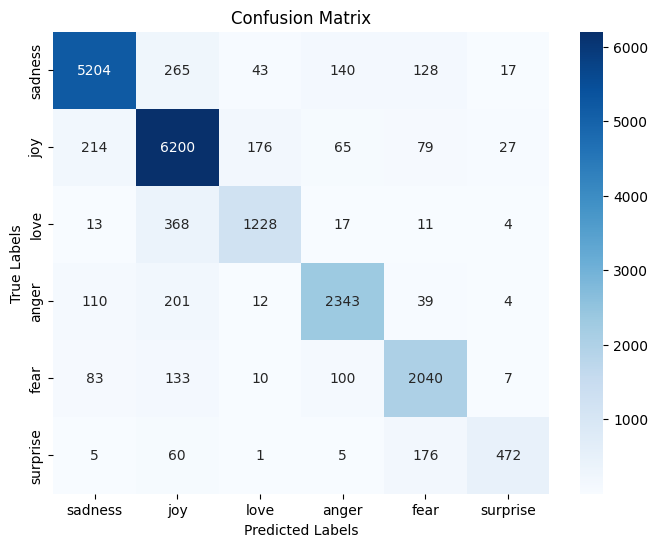

In [5]:
y_pred = clf.predict(X)  # predict with the best clf
plot_cm(y, y_pred)

### 2. RF with adjusted class weights
If we want to focus on users with more negative messages (ie, sadness, anger, fear), we can probably put higher weights on those classes to let the model classify them better.

In [4]:
labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]
counts = np.bincount(y)
weights = y.shape[0] / (5 * np.bincount(y)) 
potential_weights = {0: 1.38, 1: 1, 2: 1, 3: 2, 4: 2, 5: 1}  # say more weights on sadness, anger, fear

pd.DataFrame({
    'labels': labels,
    'counts': counts,
    'balanced weights': weights,
    'potential weights': potential_weights.values()
})

,labels,counts,balanced weights,potential weights
0,sadness,5797,0.690012,1.38
1,joy,6761,0.591628,1.00
2,love,1641,2.437538,1.00
3,anger,2709,1.476560,2.00
4,fear,2373,1.685630,2.00
5,surprise,719,5.563282,1.00


In [5]:
def rf_weighted(X, y, weights):
    scoring = 'f1_weighted'  # scoring methods: https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values

    parameters = {
        'n_estimators': [50, 100, 200],
        'max_depth': [150, 200, 300],
        'min_samples_leaf': [5, 10, 20, 30]  # The minimum number of samples required to be at a leaf node.
    }
    
    rf = RandomForestClassifier(class_weight=weights, random_state=seed)
    clf = GridSearchCV(rf, parameters, scoring='f1_weighted', cv=5)  # grid search with cross validation
    clf.fit(X, y)

    score = clf.best_score_
    param = clf.best_params_

    print(f'Best {scoring} score: {round(score, 2)}\n Best params: {param}')

    return clf

clf = rf_weighted(X, y, potential_weights)

Best f1_weighted score: 0.86
 Best params: {'max_depth': 300, 'min_samples_leaf': 5, 'n_estimators': 200}


              precision    recall  f1-score   support

     sadness       0.94      0.88      0.91      5797
         joy       0.86      0.92      0.89      6761
        love       0.86      0.73      0.79      1641
       anger       0.84      0.90      0.87      2709
        fear       0.80      0.88      0.84      2373
    surprise       0.92      0.61      0.73       719

    accuracy                           0.87     20000
   macro avg       0.87      0.82      0.84     20000
weighted avg       0.88      0.87      0.87     20000



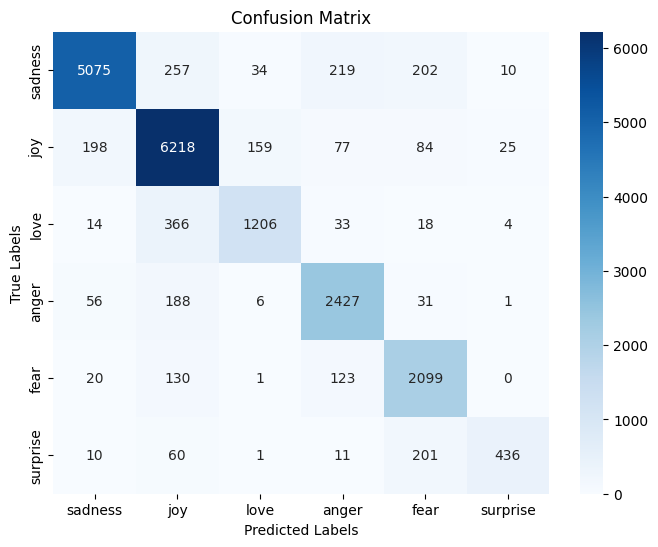

In [6]:
y_pred = clf.predict(X)  # predict with the best clf
plot_cm(y, y_pred)

### 3. RF with random oversampling
Random over-sampling the not majority class: Resampled dataset shape Counter({0: 6761, 3: 6761, 2: 6761, 5: 6761, 4: 6761, 1: 6761})

In [66]:
def rf_oversampling(X, y):
    scoring = 'f1_weighted'  # scoring methods: https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values

    parameters = {
        'n_estimators': [50, 100, 200],
        'max_depth': [150, 200, 300],
        'min_samples_leaf': [5, 10, 20, 30]  # The minimum number of samples required to be at a leaf node.
    }
    params = {'randomforestclassifier__' + key: parameters[key] for key in parameters}
    
    rf = RandomForestClassifier(random_state=seed)
    sampler = RandomOverSampler(sampling_strategy='not majority', random_state=seed)
    
    pipeline = make_pipeline(sampler, rf)
    clf = GridSearchCV(pipeline, params, scoring='f1_weighted', cv=5)
    clf.fit(X, y)

    score = clf.best_score_
    param = clf.best_params_

    print(f'Best {scoring} score: {round(score, 2)}\n Best params: {param}')

    return clf

clf = rf_oversampling(X, y)

Best f1_weighted score: 0.86
 Best params: {'randomforestclassifier__max_depth': 300, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__n_estimators': 50}


              precision    recall  f1-score   support

     sadness       0.96      0.85      0.91      5797
         joy       0.92      0.85      0.88      6761
        love       0.68      0.96      0.79      1641
       anger       0.84      0.90      0.87      2709
        fear       0.87      0.83      0.85      2373
    surprise       0.63      0.99      0.77       719

    accuracy                           0.87     20000
   macro avg       0.82      0.90      0.85     20000
weighted avg       0.89      0.87      0.87     20000



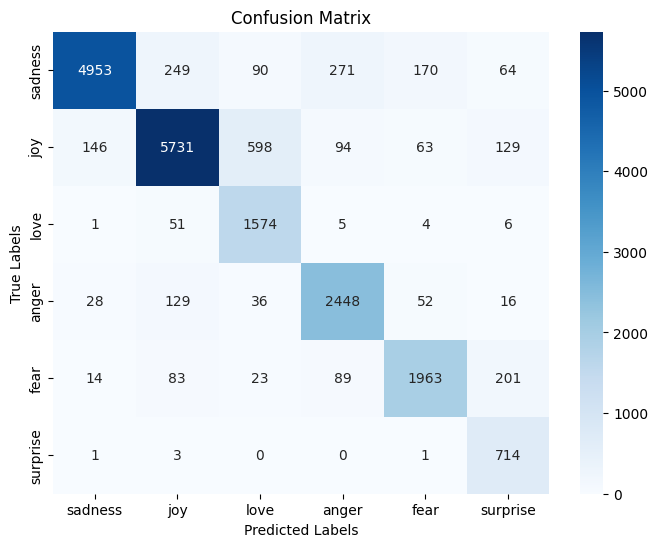

In [67]:
y_pred = clf.predict(X)  # predict with the best clf
plot_cm(y, y_pred)

### 4. RF with SMOTE

In [68]:
def rf_smote(X, y):
    scoring = 'f1_weighted'  # scoring methods: https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values

    parameters = {
        'n_estimators': [50, 100, 200],
        'max_depth': [150, 200, 300],
        'min_samples_leaf': [5, 10, 20, 30]  # The minimum number of samples required to be at a leaf node.
    }
    params = {'randomforestclassifier__' + key: parameters[key] for key in parameters}
    
    rf = RandomForestClassifier(random_state=seed)
    sampler = SMOTE(sampling_strategy='not majority', random_state=seed)
    
    pipeline = make_pipeline(sampler, rf)
    clf = GridSearchCV(pipeline, params, scoring='f1_weighted', cv=5)
    clf.fit(X, y)

    score = clf.best_score_
    param = clf.best_params_

    print(f'Best {scoring} score: {round(score, 2)}\n Best params: {param}')

    return clf

clf = rf_smote(X, y)

Best f1_weighted score: 0.84
 Best params: {'randomforestclassifier__max_depth': 300, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__n_estimators': 200}


              precision    recall  f1-score   support

     sadness       0.95      0.84      0.89      5797
         joy       0.95      0.83      0.88      6761
        love       0.62      0.95      0.75      1641
       anger       0.81      0.91      0.86      2709
        fear       0.83      0.81      0.82      2373
    surprise       0.60      0.98      0.74       719

    accuracy                           0.85     20000
   macro avg       0.79      0.88      0.82     20000
weighted avg       0.88      0.85      0.86     20000



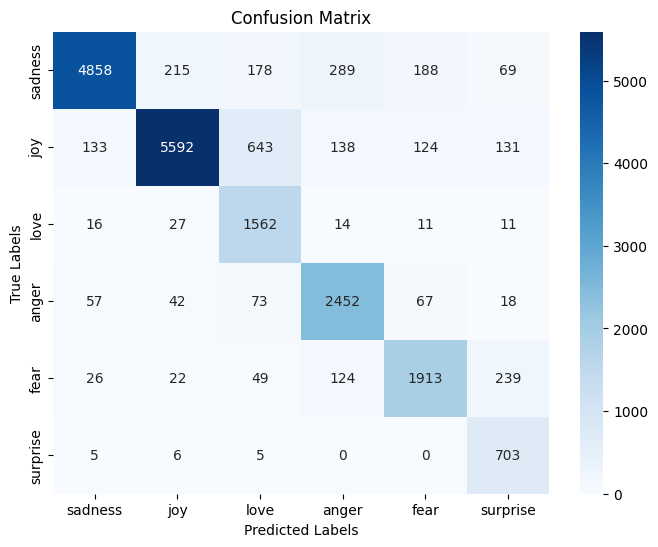

In [69]:
y_pred = clf.predict(X)  # predict with the best clf
plot_cm(y, y_pred)

### Questions
- How about the change in with-class precision, accuracy, f1?
- What's the better metric than F1?
- Are F1 scores varying when using other models with oversampling?